<a href="https://colab.research.google.com/github/gibi177/NOIA/blob/main/Problema%20MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron Multicamada no problema MNIST



### Disciplina: Noções de Inteligência Artificial - 2/2024
### Alunos: Felipe Lopes Gibin Duarte e Matheus das Neves Fernandes

## Introdução


Este trabalho implementa um Perceptron Multicamada (MLP) para resolver o problema de classificação de dígitos manuscritos do conjunto de dados MNIST. Foram exploradas diferentes arquiteturas e técnicas de treinamento, avaliando o desempenho de cada abordagem.


## 1. Preparação do Ambiente
Nesta seção, importamos as bibliotecas necessárias, carregamos o conjunto de dados MNIST e preparamos o dataloader


### 1.1. Importação de Bibliotecas

In [1]:
!pip install d2l==1.0.3

import tensorflow as tf
from d2l import tensorflow as d2l
d2l.use_svg_display()
import pdb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 294.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successful

### 1.2. Carregamento e Pré-processamento dos Dados

In [2]:
class MNIST(d2l.DataModule):  # @save
    """O dataset MNIST."""

    def __init__(self, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.mnist.load_data()

    def get_dataloader(self, train):
        data = self.train if train else self.val
        process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,tf.cast(y, dtype='int32'))
        resize_fn = lambda X, y: (tf.image.resize_with_pad(X,*self.resize), y)
        shuffle_buf = len(data[0]) if train else 1
        return tf.data.Dataset.from_tensor_slices(process(*data)).batch(self.batch_size).shuffle(shuffle_buf)

#Instancia o dataset
data = MNIST()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# Verifica o número de exemplos e formato dos dados
print(len(data.train[0]), len(data.val[0]))
print(data.train[0].shape)

60000 10000
(60000, 28, 28)


In [4]:
#Verifica um minibatch
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

(64, 28, 28, 1) <dtype: 'float32'> (64,) <dtype: 'int32'>


## 2. Modelos e Arquiteturas
Nesta seção, implementamos diferentes arquiteturas e técnicas de treinamento para o MLP, avaliando o impacto no desempenho.


### 2a. Perceptron com uma Camada Escondida, Função Logística, Custo SSE e Descida de Gradiente


In [5]:
# Converte os rótulos para One-Hot
def preprocess_labels(dataset):
    return dataset.map(lambda X, y: (X, tf.one_hot(y, depth=10)))

# Prepara os dados para treinamento com os rotulos processados
train_dataloader = preprocess_labels(data.get_dataloader(train=True))
val_dataloader = preprocess_labels(data.get_dataloader(train=False))

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(128, activation='sigmoid'),   #Camada escondida
    tf.keras.layers.Dense(10, activation='sigmoid')  #Camada de saída
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.1),   #Descida por gradiente
    loss=tf.keras.losses.MeanSquaredError(),  #Erro quadrático médio
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                       # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2a = model

#Identificação do modelo
model_name = "2a - função de ativação sigmoide, descida de gradiente"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2510 - loss: 0.1007 - val_accuracy: 0.4499 - val_loss: 0.0834
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4592 - loss: 0.0814 - val_accuracy: 0.5661 - val_loss: 0.0739
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5903 - loss: 0.0717 - val_accuracy: 0.6870 - val_loss: 0.0642
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6886 - loss: 0.0628 - val_accuracy: 0.7474 - val_loss: 0.0560
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7472 - loss: 0.0551 - val_accuracy: 0.7848 - val_loss: 0.0498
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7777 - loss: 0.0493 - val_accuracy: 0.8111 - val_loss: 0.0450
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8038 - loss: 0.0450 - val_accuracy: 0.8265 - val_loss: 0.0413
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8196 - loss: 0.0413 - val_accuracy: 0.

### 2b. Saída do tipo softmax, custo "entropia cruzada"

In [7]:
# Prepara os dados de treinamento sem conversão para One-Hot
train_dataloader = data.get_dataloader(train=True)
val_dataloader = data.get_dataloader(train=False)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(128, activation='sigmoid'),   #Camada escondida
    tf.keras.layers.Dense(10, activation='softmax')  #Camada de saída
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.1),   #Descida por gradiente
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                      # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2b = model

#Identificação do modelo
model_name = "2b - saida softmax, função de custo entropia cruzada"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7283 - loss: 1.1078 - val_accuracy: 0.9015 - val_loss: 0.3752
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8979 - loss: 0.3703 - val_accuracy: 0.9136 - val_loss: 0.3088
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9105 - loss: 0.3093 - val_accuracy: 0.9204 - val_loss: 0.2812
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9179 - loss: 0.2854 - val_accuracy: 0.9263 - val_loss: 0.2642
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9238 - loss: 0.2643 - val_accuracy: 0.9295 - val_loss: 0.2449
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9290 - loss: 0.2487 - val_accuracy: 0.9345 - val_loss: 0.2308
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9320 - loss: 0.2349 - val_accuracy: 0.9383 - val_loss: 0.2183
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9377 - loss: 0.2174 - val_accuracy: 0.

### 2c. Otimizador Adam

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(128, activation='sigmoid'),   #Camada escondida
    tf.keras.layers.Dense(10, activation='softmax')  #Camada de saída
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                      # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2c = model

#Identificação do modelo
model_name = "2c - função de ativação sigmoide, otimizador Adam"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8055 - loss: 0.8025 - val_accuracy: 0.9251 - val_loss: 0.2643
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9276 - loss: 0.2520 - val_accuracy: 0.9416 - val_loss: 0.1998
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9464 - loss: 0.1896 - val_accuracy: 0.9506 - val_loss: 0.1701
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9559 - loss: 0.1560 - val_accuracy: 0.9567 - val_loss: 0.1472
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9636 - loss: 0.1268 - val_accuracy: 0.9628 - val_loss: 0.1275
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9692 - loss: 0.1087 - val_accuracy: 0.9633 - val_loss: 0.1211
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9740 - loss: 0.0928 - val_accuracy: 0.9659 - val_loss: 0.1113
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9772 - loss: 0.0811 - val_accuracy: 0.

### 2d. A função Relu

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(128, activation='relu'),   #Camada escondida
    tf.keras.layers.Dense(10, activation='softmax')  #Camada de saída
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                      # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2d = model

#Identificação do modelo
model_name = "2d - função de ativação relu, otimizador Adam"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8561 - loss: 0.5199 - val_accuracy: 0.9532 - val_loss: 0.1609
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9565 - loss: 0.1468 - val_accuracy: 0.9658 - val_loss: 0.1186
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9696 - loss: 0.1060 - val_accuracy: 0.9701 - val_loss: 0.1019
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9781 - loss: 0.0736 - val_accuracy: 0.9757 - val_loss: 0.0798
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9849 - loss: 0.0557 - val_accuracy: 0.9758 - val_loss: 0.0808
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9855 - loss: 0.0485 - val_accuracy: 0.9746 - val_loss: 0.0797
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9891 - loss: 0.0366 - val_accuracy: 0.9762 - val_loss: 0.0772
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9914 - loss: 0.0296 - val_accuracy: 0.

### 2e. Redes maiores

#### Camada escondida com 256 neurônios

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(256, activation='relu'),   #Camada escondida
    tf.keras.layers.Dense(10, activation='softmax')  #Camada de saída
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                      # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2e1 = model

#Identificação do modelo
model_name = "2e.1 - 1 camada escondida de 256 neurônios"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8725 - loss: 0.4435 - val_accuracy: 0.9581 - val_loss: 0.1420
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9662 - loss: 0.1162 - val_accuracy: 0.9712 - val_loss: 0.0929
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9768 - loss: 0.0747 - val_accuracy: 0.9745 - val_loss: 0.0818
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9836 - loss: 0.0547 - val_accuracy: 0.9746 - val_loss: 0.0753
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9883 - loss: 0.0383 - val_accuracy: 0.9786 - val_loss: 0.0727
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9907 - loss: 0.0310 - val_accuracy: 0.9777 - val_loss: 0.0713
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9935 - loss: 0.0226 - val_accuracy: 0.9787 - val_loss: 0.0703
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9958 - loss: 0.0159 - val_accuracy: 0.

#### 2 camadas escondidas com 256 neurônios cada

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(256, activation='relu'),   #Camada escondida 1
    tf.keras.layers.Dense(256, activation='relu'),   #Camada escondida 2
    tf.keras.layers.Dense(10, activation='softmax')  #Camada de saída
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                      # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2e2 = model

#Identificação do modelo
model_name = "2e.2 - 2 camadas escondidas de 256 neurônios"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8865 - loss: 0.4007 - val_accuracy: 0.9662 - val_loss: 0.1139
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9708 - loss: 0.0925 - val_accuracy: 0.9728 - val_loss: 0.0926
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9813 - loss: 0.0592 - val_accuracy: 0.9749 - val_loss: 0.0798
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9863 - loss: 0.0424 - val_accuracy: 0.9771 - val_loss: 0.0732
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9895 - loss: 0.0329 - val_accuracy: 0.9789 - val_loss: 0.0776
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9921 - loss: 0.0242 - val_accuracy: 0.9792 - val_loss: 0.0718
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9931 - loss: 0.0208 - val_accuracy: 0.9783 - val_loss: 0.0765
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9935 - loss: 0.0187 - val_accuracy: 0.

## 3. Visualização
Nesta seção, vamos observar alguns exemplos mal classificados

In [13]:
# Predição no conjunto de validação e identificação de erros
def get_errors(data_loader, model):
    erros = []  # Lista para armazenar os exemplos mal classificados
    for X, y in data_loader:  # Iterar sobre o dataloader de validação
        preds = tf.argmax(model(X), axis=1)  # Previsões (classe com maior probabilidade)
        y = tf.cast(y, dtype=tf.int64)  # Converte rótulos para int64
        erros_batch = tf.where(preds != y)  # Identifica índices dos erros
        for idx in erros_batch.numpy():
            idx = idx.item()  # Extrai o valor escalar do tensor
            erros.append((X[idx].numpy(), y[idx].numpy(), preds[idx].numpy()))  # Armazena a imagem, rótulo real e predição errada
    return erros

In [14]:
def visualize_errors(erros, num_samples):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_samples, len(erros))):
        img, true_label, pred_label = erros[i]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')  # Exibe a imagem
        plt.title(f"Real: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.show()

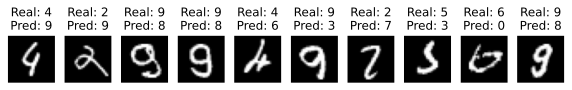

Número total de erros: 199
Modelo avaliado: 2e.1 - 1 camada escondida de 256 neurônios


In [15]:
# Obter erros no conjunto de validação do modelo especificado (neste caso o 2e1)
erros = get_errors(val_dataloader, model_2e1)

# Associar erros ao nome do modelo
erros_modelo = {"nome": model_name, "erros": erros}

# Visualizar erros (nesse caso do modelo 2e.1)
model_name = "2e.1 - 1 camada escondida de 256 neurônios"
visualize_errors(erros_modelo["erros"], num_samples=10)

print(f"Número total de erros: {len(erros)}")
print(f"Modelo avaliado: {model_name}")

É possível perceber que em alguns casos a identificação exata do dígito realmente se torna difícil com a diferenciação por humanos e acertada pela máquina, no caso a rede neural. Porém, há casos mais claros e fáceis de serem preditados, os quais a máquina erra.

## 4. Matriz de confusão
Vamos observar a matriz de confusão do melhor modelo (2e.1)

In [16]:
def get_predictions_and_labels(data_loader, model):
    y_true = []  # Lista para rótulos verdadeiros
    y_pred = []  # Lista para predições
    for X, y in data_loader:  # Iterar sobre o dataloader
        preds = tf.argmax(model(X), axis=1)  # Previsões (classe com maior probabilidade)
        y_true.extend(y.numpy().tolist())  # Adicionar rótulos verdadeiros
        y_pred.extend(preds.numpy().tolist())  # Adicionar predições
    return y_true, y_pred

In [17]:
def calculate_confusion_matrix(y_true, y_pred, num_classes):
    # Inicializa a matriz de confusão com zeros
    matriz = [[0 for _ in range(num_classes)] for _ in range(num_classes)]

    # Popula a matriz de confusão
    for true, pred in zip(y_true, y_pred):
        matriz[true][pred] += 1

    return matriz

In [18]:
def plot_confusion_matrix(matriz, class_names):
    plt.figure(figsize=(8, 8))
    num_classes = len(class_names)
    plt.imshow(matriz, interpolation='nearest', cmap='Blues')
    plt.title("Matriz de Confusão")
    plt.colorbar()
    plt.xticks(range(num_classes), class_names, rotation=45)
    plt.yticks(range(num_classes), class_names)

    # Exibir os valores dentro da matriz
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, str(matriz[i][j]), horizontalalignment="center", color="white" if matriz[i][j] > max(map(max, matriz)) // 2 else "black")

    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Verdadeira")
    plt.tight_layout()
    plt.show()

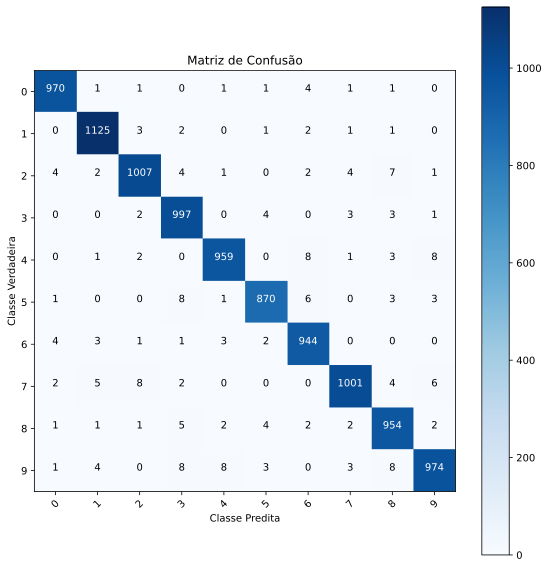

In [19]:
# Escolher modelo a ser usado (neste caso o 2e1)
model = model_2e1

# Obter rótulos e predições
y_true, y_pred = get_predictions_and_labels(val_dataloader, model)

# Calcular a matriz de confusão
matriz_confusao = calculate_confusion_matrix(y_true, y_pred, num_classes=10)

# Plotar a matriz de confusão
classes = [str(i) for i in range(10)]  # Nomes das classes
plot_confusion_matrix(matriz_confusao, classes)

Na Matriz de Confusão, conseguimos perceber alguns padrões nos casos mais frequentes de "confusão". Isto acontece principalmente pela maior similaridade visual entre o caso real e o caso preditado.